In [1]:
from deephive.optimizers import deephive as dh 
from deephive.environment.utils import * 
from datetime import datetime
import os 
import neptune 
from deephive.environment.deephive_utils import *
import torch

Using device: cpu


In [2]:
config_path = "../config/exp_config.json"
model_path = "../models/pbest_unfreeze.pth"
model_path_2 = "../models/gbest.pth"

def initialize_logger(api_token, tags, config, mode="train"):
    run = neptune.init_run(
    project="DMO-LAB/DeepHive-V2",
    source_files=["environment", "policies", "deephive.py", "config"],
    api_token=api_token,
    tags=[tags, mode, config["objective_function"], str(config["layer_size"])]
    )
    neptune_logger = run
    return neptune_logger

def get_action(observation_info, agent_policy, env, observation_std=None, random=False):
    # Ensure observation_info is a numpy array
    
    if random:
        print("Random action")
        return env.action_space.sample()
    
    observation = observation_info
    if not isinstance(observation, np.ndarray):
        observation = np.array(observation)
        assert observation.shape[0] == env.n_dim, "Observation must have the same number of dimensions as the environment"

    # Initialize observation_std with zeros or use provided std, ensuring it matches the shape of observation
    if observation_std is None:
        observation_std = np.zeros_like(observation)
    else:
        observation_std = np.array(observation_std)

    # Convert observations and stds to the appropriate format (Flatten if necessary)
    # Assuming observation and observation_std are 2D arrays of shape (n_agents, n_dim)
    # Flatten observation and observation_std for processing
    observation_flat = observation.reshape(env.n_dim * env.n_agents, -1)  # Flatten to 1D array
    observation_std_flat = observation_std.reshape(-1)  # Flatten to 1D array
    # Pass the entire flattened observation and std arrays to select_action
    action_flat = agent_policy.select_action(observation_flat, observation_std_flat)

    # Reshape the flattened action array back to the original (n_agents, n_dim) shape
    actions = action_flat.reshape(env.n_dim, env.n_agents).T  # Reshape to (n_agents, n_dim

    return actions  # Return the action



In [5]:
config = parse_config(config_path)
config["update_timestep"] = 25 
config["decay_rate"] = 0.99
config["n_dim"] = 2
config["include_gbest"] = False 
if config["include_gbest"]:
    config["obs_dim"] = 11
config["n_agents"] = 10
config["ep_length"] = 25
config["log_interval"] = 500
config["decay_interval"] = 1000
config["save_interval"] = 25000
config["min_action_std"] = 0.02
config["n_episodes"] = 5000
config["update_start"] = 0
config["action_std"] = 0.3
config["variable_std"]  = False
config["reward_scheme"] = "FullRewardScheme"
config['use_gbest'] = False
config['objective_function'] = "CEC17"
config["function_id"] = 0  
config["use_optimal_value"] = True 
config["log_scale"] = True
mode = "train"
log = False 
tags = "new reward training"
env, agent_policy = initialize(config, mode=mode, model_path=model_path)
neptune_logger = None

In [6]:
obs = env.reset()
opt_params=np.array([[-55.2763985 , -70.42955972]])
agent_policy.action_std

0.3

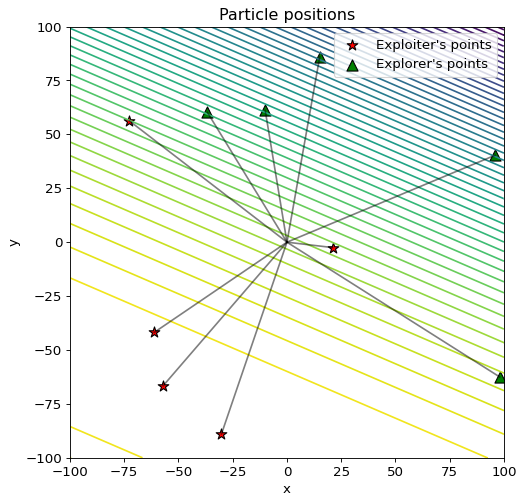

In [7]:
env.render()

In [8]:

def train_agent(env, agent_policy, title, config, neptune_logger, n_episodes=None, update_timestep=None, decay_rate=None, log_interval=None, decay_interval=None, save_interval=None, min_action_std=None):
    # if parameters are not provided, use the ones from the config file
    if update_timestep is None:
        update_timestep = config["update_timestep"]
    if decay_rate is None:
        decay_rate =  config["decay_rate"]
    if log_interval is None:
        log_interval =  config["log_interval"]
    if decay_interval is None:
        decay_interval =  config["decay_interval"]
    if save_interval is None:
        save_interval =  config["save_interval"]
    if min_action_std is None:
        min_action_std =  config["min_action_std"]
    if n_episodes is None:
        n_episodes =  config["n_episodes"]

    average_returns = []
    training_run_title = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    training_run_title = title + "_" + training_run_title
    save_path = f"training_runs/{training_run_title}/"
    os.makedirs(save_path, exist_ok=True)
    timesteps = 0
    for episode in range(0, n_episodes+1):
        # if timesteps < config["update_start"]:
        #     print(f"Using random actions for episode {episode} - timesteps: {timesteps}")
        # if episode % log_interval == 0:
        #     print(f"Episode: {episode}, timesteps: {timesteps}")
        observation_info =  env.reset()
        obs, obs_std = observation_info 
        episode_return = np.zeros( env.n_agents)
        for step in range( env.ep_length):
            # if timesteps < config["update_start"]:
            #     actions =  get_action(obs, agent_policy, env, obs_std, random=True)
            # else:
                # print(f"Using policy actions for episode {episode} - timesteps: {timesteps}")
            actions =  get_action(obs, agent_policy, env, obs_std, random=False)
            observation_info, reward, done, info =  env.step(actions)
            obs, obs_std = observation_info
            # add reward to agent buffer
            for ag in range( env.n_agents):
                 agent_policy.buffer.rewards += [reward[ag]] *  env.n_dim
                 agent_policy.buffer.is_terminals += [done[ag]] *  env.n_dim
            
            episode_return += reward
            if  neptune_logger and episode % log_interval == 0:
                # log global best agent value
                neptune_logger[f"train/global_best_value/episode{episode}"].log(float(info["gbest"][-1]))
                    
            if step ==  env.ep_length - 1:
                average_returns.append(np.mean(episode_return))
                running_average_rewards = np.mean(average_returns)
                if neptune_logger:
                    neptune_logger["train/average_return"].log(average_returns[-1])
                    neptune_logger["train/percentage_high_std"].log( env.surrogate.percent_high_std)
            timesteps += 1
        
        if timesteps % update_timestep == 0:
            #print(f"Updating policy at timestep {timesteps}")
            agent_policy.update()
    
        if timesteps > 0 and episode % log_interval == 0:
            print_items(
                    episode = episode,
                    average_returns = average_returns[-1],
                    timesteps = timesteps,
                    )
            if env.n_dim <= 2 and episode % log_interval == 0:
                env.render(file_path=f"{save_path}{episode}.gif", type="history")
                if neptune_logger:
                    neptune_logger[f"train/gifs/{episode}.gif"].upload(f"{save_path}{episode}.gif")
                    
        if timesteps % decay_interval == 0:
            print(f"Decaying action std at timestep {timesteps}")
            agent_policy.decay_action_std(decay_rate, min_action_std=min_action_std, debug=True)
            
        if timesteps % save_interval == 0 and timesteps > 0:
            if average_returns[-1] > running_average_rewards:
                print(f"Average return: {average_returns[-1]}, running average: {running_average_rewards}")
                agent_policy.save(save_path, episode=timesteps)
                if  neptune_logger:
                    neptune_logger[f"train/checkpoints/timesteps-{timesteps}"].upload(f"{save_path}/policy-{timesteps}.pth")
                    
                    


episode 0
average_returns -53.435134046977325
timesteps 25


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/0.gif
Decaying action std at timestep 1000
[INFO]: setting action std to 0.297
Decaying action std at timestep 2000
[INFO]: setting action std to 0.294
Decaying action std at timestep 3000
[INFO]: setting action std to 0.2911
Decaying action std at timestep 4000
[INFO]: setting action std to 0.2882
Decaying action std at timestep 5000
[INFO]: setting action std to 0.2853
Decaying action std at timestep 6000
[INFO]: setting action std to 0.2824
Decaying action std at timestep 7000
[INFO]: setting action std to 0.2796
Decaying action std at timestep 8000
[INFO]: setting action std to 0.2768
Decaying action std at timestep 9000
[INFO]: setting action std to 0.274
Decaying action std at timestep 10000
[INFO]: setting action std to 0.2713
Decaying action std at timestep 11000
[INFO]: setting action std to 0.2686
Decaying action std at timestep 12000
[INFO]: setting action std to 0.2659
episode 500
average_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/500.gif
Decaying action std at timestep 13000
[INFO]: setting action std to 0.2632
Decaying action std at timestep 14000
[INFO]: setting action std to 0.2606
Decaying action std at timestep 15000
[INFO]: setting action std to 0.258
Decaying action std at timestep 16000
[INFO]: setting action std to 0.2554
Decaying action std at timestep 17000
[INFO]: setting action std to 0.2528
Decaying action std at timestep 18000
[INFO]: setting action std to 0.2503
Decaying action std at timestep 19000
[INFO]: setting action std to 0.2478
Decaying action std at timestep 20000
[INFO]: setting action std to 0.2453
Decaying action std at timestep 21000
[INFO]: setting action std to 0.2428
Decaying action std at timestep 22000
[INFO]: setting action std to 0.2404
Decaying action std at timestep 23000
[INFO]: setting action std to 0.238
Decaying action std at timestep 24000
[INFO]: setting action std to 0.2356
Decaying

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/1000.gif
Decaying action std at timestep 26000
[INFO]: setting action std to 0.2309
Decaying action std at timestep 27000
[INFO]: setting action std to 0.2286
Decaying action std at timestep 28000
[INFO]: setting action std to 0.2263
Decaying action std at timestep 29000
[INFO]: setting action std to 0.224
Decaying action std at timestep 30000
[INFO]: setting action std to 0.2218
Decaying action std at timestep 31000
[INFO]: setting action std to 0.2196
Decaying action std at timestep 32000
[INFO]: setting action std to 0.2174
Decaying action std at timestep 33000
[INFO]: setting action std to 0.2152
Decaying action std at timestep 34000
[INFO]: setting action std to 0.213
Decaying action std at timestep 35000
[INFO]: setting action std to 0.2109
Decaying action std at timestep 36000
[INFO]: setting action std to 0.2088
Decaying action std at timestep 37000
[INFO]: setting action std to 0.2067
episode

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/1500.gif
Decaying action std at timestep 38000
[INFO]: setting action std to 0.2046
Decaying action std at timestep 39000
[INFO]: setting action std to 0.2026
Decaying action std at timestep 40000
[INFO]: setting action std to 0.2006
Decaying action std at timestep 41000
[INFO]: setting action std to 0.1986
Decaying action std at timestep 42000
[INFO]: setting action std to 0.1966
Decaying action std at timestep 43000
[INFO]: setting action std to 0.1946
Decaying action std at timestep 44000
[INFO]: setting action std to 0.1927
Decaying action std at timestep 45000
[INFO]: setting action std to 0.1908
Decaying action std at timestep 46000
[INFO]: setting action std to 0.1889
Decaying action std at timestep 47000
[INFO]: setting action std to 0.187
Decaying action std at timestep 48000
[INFO]: setting action std to 0.1851
Decaying action std at timestep 49000
[INFO]: setting action std to 0.1832
Decayi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/2000.gif
Decaying action std at timestep 51000
[INFO]: setting action std to 0.1796
Decaying action std at timestep 52000
[INFO]: setting action std to 0.1778
Decaying action std at timestep 53000
[INFO]: setting action std to 0.176
Decaying action std at timestep 54000
[INFO]: setting action std to 0.1742
Decaying action std at timestep 55000
[INFO]: setting action std to 0.1725
Decaying action std at timestep 56000
[INFO]: setting action std to 0.1708
Decaying action std at timestep 57000
[INFO]: setting action std to 0.1691
Decaying action std at timestep 58000
[INFO]: setting action std to 0.1674
Decaying action std at timestep 59000
[INFO]: setting action std to 0.1657
Decaying action std at timestep 60000
[INFO]: setting action std to 0.164
Decaying action std at timestep 61000
[INFO]: setting action std to 0.1624
Decaying action std at timestep 62000
[INFO]: setting action std to 0.1608
episode

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/2500.gif
Decaying action std at timestep 63000
[INFO]: setting action std to 0.1592
Decaying action std at timestep 64000
[INFO]: setting action std to 0.1576
Decaying action std at timestep 65000
[INFO]: setting action std to 0.156
Decaying action std at timestep 66000
[INFO]: setting action std to 0.1544
Decaying action std at timestep 67000
[INFO]: setting action std to 0.1529
Decaying action std at timestep 68000
[INFO]: setting action std to 0.1514
Decaying action std at timestep 69000
[INFO]: setting action std to 0.1499
Decaying action std at timestep 70000
[INFO]: setting action std to 0.1484
Decaying action std at timestep 71000
[INFO]: setting action std to 0.1469
Decaying action std at timestep 72000
[INFO]: setting action std to 0.1454
Decaying action std at timestep 73000
[INFO]: setting action std to 0.1439
Decaying action std at timestep 74000
[INFO]: setting action std to 0.1425
Decayi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/3000.gif
Decaying action std at timestep 76000
[INFO]: setting action std to 0.1397
Decaying action std at timestep 77000
[INFO]: setting action std to 0.1383
Decaying action std at timestep 78000
[INFO]: setting action std to 0.1369
Decaying action std at timestep 79000
[INFO]: setting action std to 0.1355
Decaying action std at timestep 80000
[INFO]: setting action std to 0.1341
Decaying action std at timestep 81000
[INFO]: setting action std to 0.1328
Decaying action std at timestep 82000
[INFO]: setting action std to 0.1315
Decaying action std at timestep 83000
[INFO]: setting action std to 0.1302
Decaying action std at timestep 84000
[INFO]: setting action std to 0.1289
Decaying action std at timestep 85000
[INFO]: setting action std to 0.1276
Decaying action std at timestep 86000
[INFO]: setting action std to 0.1263
Decaying action std at timestep 87000
[INFO]: setting action std to 0.125
episod

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/3500.gif
Decaying action std at timestep 88000
[INFO]: setting action std to 0.1237
Decaying action std at timestep 89000
[INFO]: setting action std to 0.1225
Decaying action std at timestep 90000
[INFO]: setting action std to 0.1213
Decaying action std at timestep 91000
[INFO]: setting action std to 0.1201
Decaying action std at timestep 92000
[INFO]: setting action std to 0.1189
Decaying action std at timestep 93000
[INFO]: setting action std to 0.1177
Decaying action std at timestep 94000
[INFO]: setting action std to 0.1165
Decaying action std at timestep 95000
[INFO]: setting action std to 0.1153
Decaying action std at timestep 96000
[INFO]: setting action std to 0.1141
Decaying action std at timestep 97000
[INFO]: setting action std to 0.113
Decaying action std at timestep 98000
[INFO]: setting action std to 0.1119
Decaying action std at timestep 99000
[INFO]: setting action std to 0.1108
Decayi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/4000.gif
Decaying action std at timestep 101000
[INFO]: setting action std to 0.1086
Decaying action std at timestep 102000
[INFO]: setting action std to 0.1075
Decaying action std at timestep 103000
[INFO]: setting action std to 0.1064
Decaying action std at timestep 104000
[INFO]: setting action std to 0.1053
Decaying action std at timestep 105000
[INFO]: setting action std to 0.1042
Decaying action std at timestep 106000
[INFO]: setting action std to 0.1032
Decaying action std at timestep 107000
[INFO]: setting action std to 0.1022
Decaying action std at timestep 108000
[INFO]: setting action std to 0.1012
Decaying action std at timestep 109000
[INFO]: setting action std to 0.1002
Decaying action std at timestep 110000
[INFO]: setting action std to 0.0992
Decaying action std at timestep 111000
[INFO]: setting action std to 0.0982
Decaying action std at timestep 112000
[INFO]: setting action std to 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/4500.gif
Decaying action std at timestep 113000
[INFO]: setting action std to 0.0962
Decaying action std at timestep 114000
[INFO]: setting action std to 0.0952
Decaying action std at timestep 115000
[INFO]: setting action std to 0.0942
Decaying action std at timestep 116000
[INFO]: setting action std to 0.0933
Decaying action std at timestep 117000
[INFO]: setting action std to 0.0924
Decaying action std at timestep 118000
[INFO]: setting action std to 0.0915
Decaying action std at timestep 119000
[INFO]: setting action std to 0.0906
Decaying action std at timestep 120000
[INFO]: setting action std to 0.0897
Decaying action std at timestep 121000
[INFO]: setting action std to 0.0888
Decaying action std at timestep 122000
[INFO]: setting action std to 0.0879
Decaying action std at timestep 123000
[INFO]: setting action std to 0.087
Decaying action std at timestep 124000
[INFO]: setting action std to 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
MovieWriter Pillow unavailable; using Pillow instead.


Creating animation
Saving animation to:  training_runs/function_0_2024-02-22_18-37-11/5000.gif


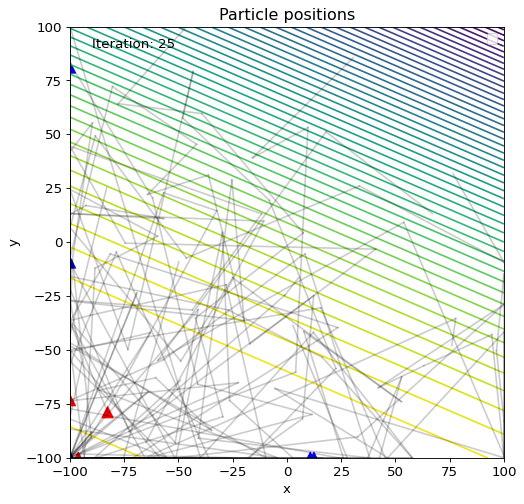

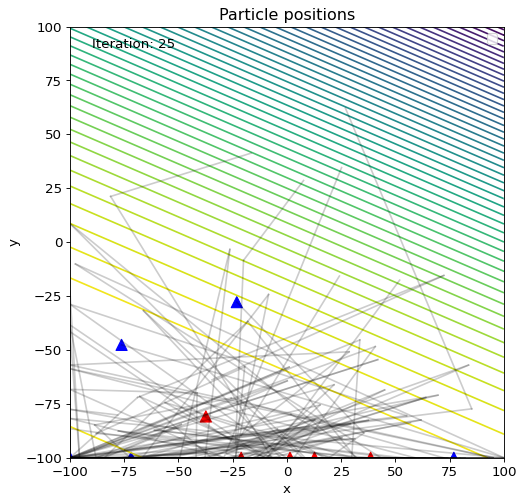

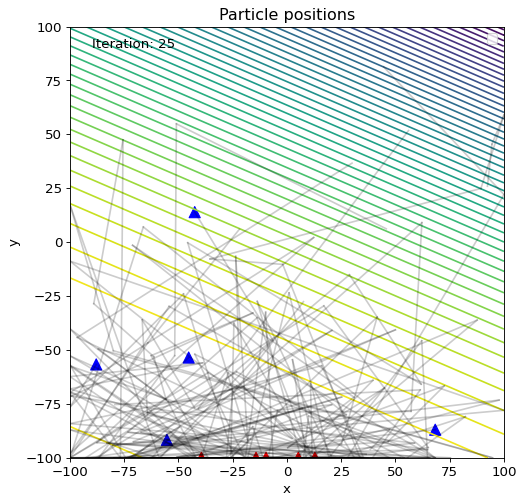

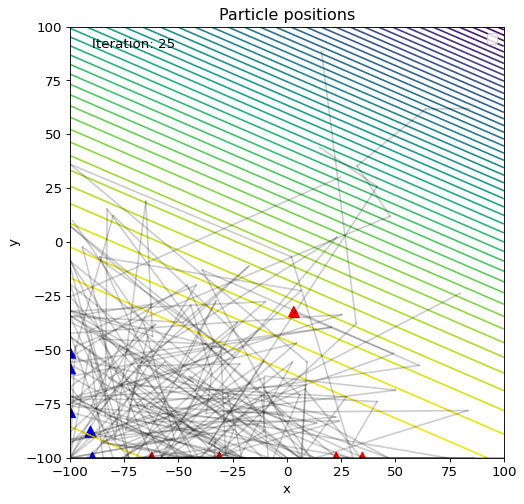

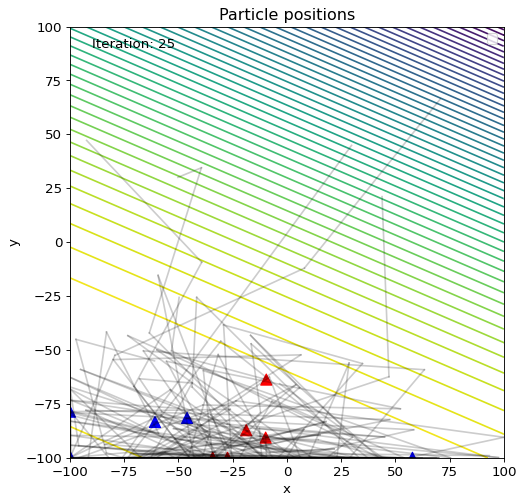

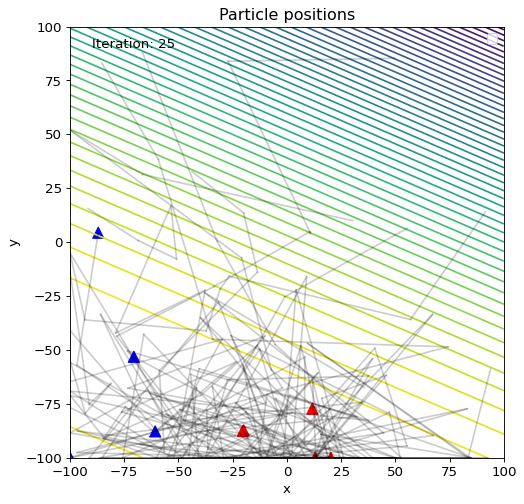

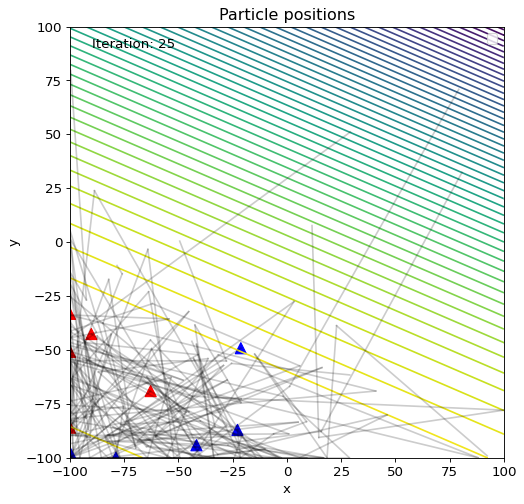

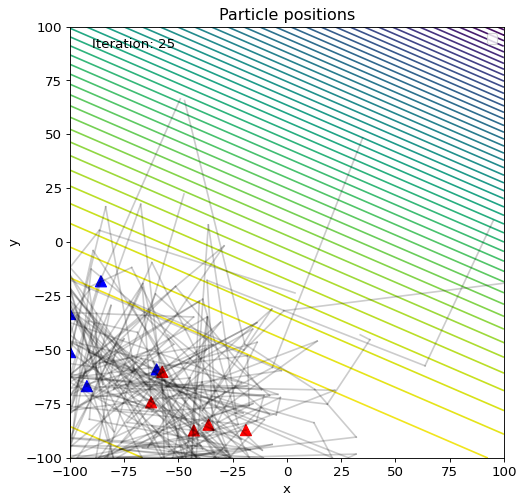

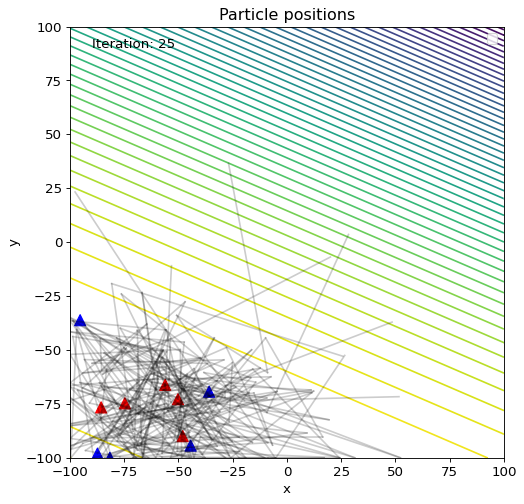

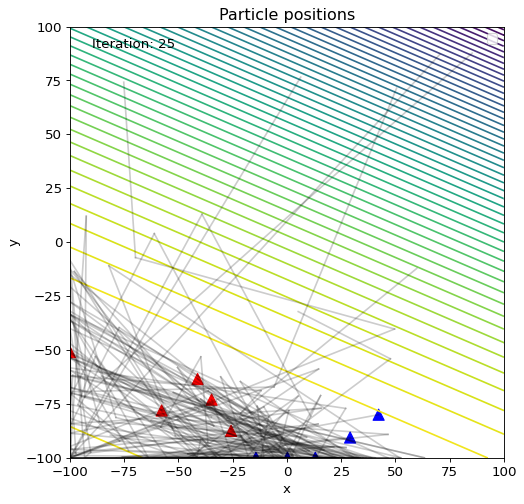

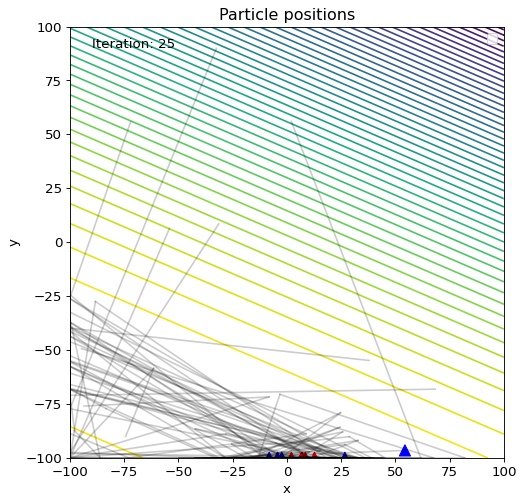

In [9]:
train_agent(env, agent_policy, "function_0", config, neptune_logger)

In [10]:
def get_direct_action(obs, obs_std, agent_policy):
    torch_obs = torch.FloatTensor(obs)
    torch_obs_std = torch.FloatTensor(obs_std)
    action = agent_policy.policy.act(torch_obs, torch_obs_std)
    return action


In [12]:
env.state

array([[0.5354, 0.    , 0.3902],
       [0.4781, 0.    , 0.2891],
       [0.5634, 0.    , 0.7065],
       [0.4881, 0.    , 0.3005],
       [0.5423, 0.    , 0.4156],
       [0.4589, 0.    , 0.2705],
       [0.5334, 0.    , 0.3841],
       [0.5101, 0.    , 0.332 ],
       [0.6334, 0.    , 0.3095],
       [0.7718, 0.0171, 0.1918]])

In [ ]:
action_dim1 = get_direct_action(obs[0], obs_std[0], agent_policy)

In [ ]:
agent_policy.set_action_std(0.00001)

## DEEPHIVE TRAINER

In [ ]:
import argparse

In [ ]:
config_path = "../config/exp_config.json"
model_path = "../models/pbest_unfreeze.pth"
model_path_2 = "../models/gbest.pth"

config = parse_config(config_path)

config["update_timestep"] = 1000
config["decay_rate"] = 0.95
config["log_interval"] = 500
config["decay_interval"] = 2000
config["save_interval"] = 2000
config["min_action_std"] = 0.02
config["n_episodes"] = 5000
config["update_start"] = 0
config["action_std"] = 0.2
config["variable_std"]  = False
config["reward_scheme"] = "FullRewardScheme"
config["use_gbest"] = False

deephive_trainer = dh.OptimizationTrainer(config, mode="train")

In [ ]:
deephive_trainer.train_agent(title="old_reward_pbest")